In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


In [3]:
!pip uninstall h5py
!pip install h5py==2.10.0
!pip install mtcnn
import os
import numpy as np
import cv2
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from keras.models import load_model,model_from_json

Found existing installation: h5py 2.10.0
Uninstalling h5py-2.10.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h5py-2.10.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h5py/*
Proceed (y/n)? n


Using TensorFlow backend.


In [4]:
model_path = "/content/drive/MyDrive/Version3/Inception_ResNet_v1.json"
json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
enc_model = model_from_json(loaded_model_json)
enc_model.load_weights('/content/drive/MyDrive/Version3/facenet_keras_weights.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [5]:
mtcnn_detector = MTCNN()

In [6]:
def detect_face(filename, required_size=(160, 160),normalize = True):
    img = Image.open(filename)
    img = img.convert('RGB')
    pixels = np.asarray(img)
    results = mtcnn_detector.detect_faces(pixels)
    if len(results)==0:
        return []
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    if normalize == True:
        mean = np.mean(face_array, axis=(0,1,2), keepdims=True)
        std = np.std(face_array, axis=(0,1,2), keepdims=True)
        std_adj = np.maximum(std, 1.0)
        return (face_array - mean) / std
    else:
        return face_array

In [8]:
known_faces_encodings = []
known_faces_ids = []
known_faces_path = "/content/drive/MyDrive/Version3/Face_database/"
for filename in os.listdir(known_faces_path):
    face = detect_face(known_faces_path+filename,normalize = True)
    if(len(face)==0):
        continue
    feature_vector = enc_model.predict(face.reshape(1,160,160,3))
    feature_vector/= np.sqrt(np.sum(feature_vector**2))
    known_faces_encodings.append(feature_vector)
    label = filename.split('.')[0]
    known_faces_ids.append(label)
known_faces_encodings = np.array(known_faces_encodings).reshape(len(known_faces_encodings),128)
known_faces_ids = np.array(known_faces_ids)

In [9]:
print(known_faces_ids.shape[0])

170


In [10]:
def recognize(img,known_faces_encodings,known_faces_ids,threshold = 0.75):
    scores = np.zeros((len(known_faces_ids),1),dtype=float)
    enc = enc_model.predict(img.reshape(1,160,160,3))
    enc/= np.sqrt(np.sum(enc**2))
    scores = np.sqrt(np.sum((enc-known_faces_encodings)**2,axis=1))
    match = np.argmin(scores)
    if scores[match] > threshold:
        return ("UNKNOWN",0)
    else:
        return (known_faces_ids[match],scores[match])

In [11]:
def face_recognition(filePath, known_faces_encodings,known_faces_ids,threshold = 0.75):
    img = cv2.imread(filePath)
    results = mtcnn_detector.detect_faces(img)
    if(len(results)==0):
        print("No face")
        return
    faces = []
    for i in range(len(results)):
        x,y,w,h = results[i]['box']
        x, y = abs(x), abs(y)
        faces.append([x,y,w,h])
    for (x, y, w, h) in faces:
        image = Image.fromarray(img[y:y+h, x:x+w])
        image = image.resize((160,160))
        face_array = asarray(image)
        mean = np.mean(face_array, axis=(0,1,2), keepdims=True)
        std = np.std(face_array, axis=(0,1,2), keepdims=True)
        std_adj = np.maximum(std, 1.0)
        face_array_normalized = (face_array - mean) / std
        label = recognize(face_array_normalized,known_faces_encodings,known_faces_ids,threshold = 0.75)
        print(label[0])

In [12]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


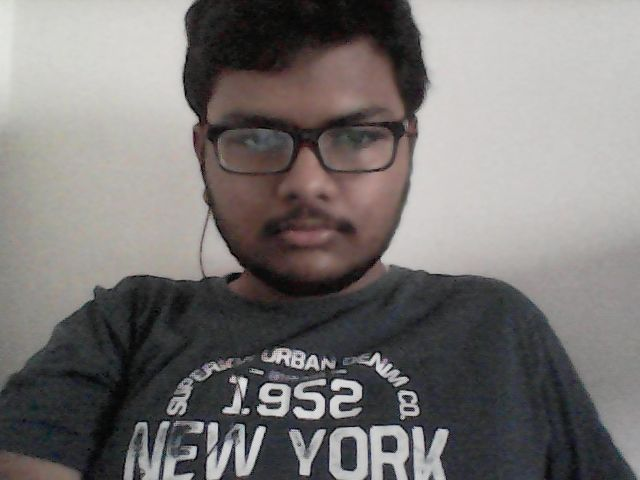

S01_(10)


In [13]:
from IPython.display import Image as imagebabu
try:
    filename = take_photo()
    print('Saved to {}'.format(filename))
    display(imagebabu(filename))
    face_recognition(filename, known_faces_encodings,known_faces_ids,threshold = 0.75)
except Exception as err:
    print(str(err))